# Agile Modeling for Bioacoustics.

This notebook provides a workflow for creating custom classifiers for target signals, by first **searching** for training data, and then engaging in an **active learning** loop.

We assume that embeddings have been pre-computed using `embed.ipynb`.

## Configuration and Imports.

In [ ]:
#@title Installation. { vertical-output: true }
#@markdown Run this notebook in Google Colab by following [this link](https://colab.research.google.com/github/google-research/perch/blob/main/agile_modeling.ipynb).
#@markdown
#@markdown Run this cell to install the project dependencies.
%pip install git+https://github.com/google-research/perch.git


In [1]:
 #@title Imports. { vertical-output: true }

import collections
from etils import epath
from ml_collections import config_dict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm
from chirp.inference import colab_utils
#colab_utils.initialize(use_tf_gpu=True, disable_warnings=True)

from chirp import audio_utils
from chirp.inference import baw_utils
from chirp.inference import tf_examples
from chirp.models import metrics
from chirp.taxonomy import namespace
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib
from chirp.projects.zoo import model_configs
from chirp.projects.zoo import zoo_interface


2024-11-08 17:46:48.931387: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 17:46:49.151978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 17:46:49.240638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 17:46:49.240684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 17:46:49.313466: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# Set default figure size globally for all plots
plt.rcParams['figure.figsize'] = [3, 2]

In [4]:
import jax
print(jax.devices())

[CpuDevice(id=0)]


In [5]:
#@title Basic Configuration. { vertical-output: true }

#@markdown Choose what data to work with.
#@markdown * For local data (most cases), choose 'filesystem'.
#@markdown * For Australian Acoustic Observatory, select 'a2o'.
#@markdown This will cause many options (like model_choice) to be overridden.
#@markdown Note that you will need an Authentication Token from:
#@markdown https://data.acousticobservatory.org/my_account
data_source = 'filesystem' #@param['filesystem', 'a2o']
baw_auth_token = '' #@param {type:'string'}

#@markdown Set the base directory for the project.
working_dir = '/mnt/e/AL_OWL_Project/'  #@param {type:'string'}

#@markdown Set the embedding and labeled data directories.
labeled_data_path = epath.Path(working_dir) / 'experiment_with_notebooks/perch_labeled_data/' #expecting path to audios
custom_classifier_path = epath.Path(working_dir) / 'custom_classifier'

#@markdown The embeddings_path should be detected automatically, but can be
#@markdown overridden.
embeddings_path = '/mnt/e/AL_OWL_Project/experiment_with_notebooks/soundscape_embed_data/'

#@markdown OPTIONAL: Set up separation model.
separation_model_key = 'separator_model_tf'  #@param {type:'string'}
separation_model_path = ''  #@param {type:'string'}


In [65]:
print(bootstrap_config.annotated_path)

/mnt/e/AL_OWL_Project/experiment_with_notebooks/perch_labeled_data


In [6]:
#@title Load Project State and Models. { vertical-output: true }

if data_source == 'a2o':
  embedding_config = baw_utils.get_a2o_embeddings_config()
  bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_config(
      embedding_config=embedding_config,
      annotated_path=labeled_data_path,
      embeddings_glob = '*/embeddings-*')
  embeddings_path = embedding_config.output_dir
elif (embeddings_path
      or (epath.Path(working_dir) / 'config.json').exists()):
  if not embeddings_path:
    # Use the default embeddings path, as it seems we found a config there.
    embeddings_path = epath.Path(working_dir) / 'embeddings'
  # Get relevant info from the embedding configuration.
  bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
      embeddings_path=embeddings_path,
      annotated_path=labeled_data_path)
  if (bootstrap_config.model_key == 'separate_embed_model'
      and not separation_model_path.strip()):
    separation_model_key = 'separator_model_tf'
    separation_model_path = bootstrap_config.model_config.separator_model_tf_config.model_path
  baw_auth_token = ''
else:
  raise ValueError('No embedding configuration found.')

project_state = bootstrap.BootstrapState(
    bootstrap_config, baw_auth_token=baw_auth_token)

# Load separation model.
if separation_model_path:
  separation_config = config_dict.ConfigDict({
      'model_path': separation_model_path,
      'frame_size': 32000,
      'sample_rate': 32000,
  })
  separator = model_configs.MODEL_CLASS_MAP[
      separation_model_key].from_config(separation_config)
  print('Loaded separator model at {}'.format(separation_model_path))
else:
  print('No separation model loaded.')
  separator = None

2024-11-08 17:47:48.496993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08 17:47:48.838723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08 17:47:48.839279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08 17:47:48.841188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08 17:47:48.841679: I external/local_xla/xla/stream_executor

No separation model loaded.


## Search Embeddings

### Query Creation

In [ ]:
#@title Load query audio. { vertical-output: true }

#@markdown You may specify:
#@markdown * an audio filepath (like `/home/me/audio/example.wav`),
#@markdown * a Xeno-Canto id (like `xc12345`), or
#@markdown * an audio file URL (like
#@markdown https://upload.wikimedia.org/wikipedia/commons/7/7c/Turdus_merula_2.ogg).
audio_path = epath.Path(working_dir) /'experiment_with_notebooks/ARD3_BO06_20191011_231400_G.bras.wav'  #@param
#@markdown Choose the start time for the audio window within the file.
#@markdown We will focus on the model's `window_size_s` seconds of audio,
#@markdown starting from `start_s` seconds into the file.
start_s = 2  #@param

window_s = bootstrap_config.model_config['window_size_s']
sample_rate = bootstrap_config.model_config['sample_rate']
audio = audio_utils.load_audio(audio_path, sample_rate)

# Display the full file.
display.plot_audio_melspec(audio, sample_rate)

# Display the selected window.
print('-' * 80)
print('Selected audio window:')
st = int(start_s * sample_rate)
end = int(st + window_s * sample_rate)
if end > audio.shape[0]:
  end = audio.shape[0]
  st = max([0, int(end - window_s * sample_rate)])
audio_window = audio[st:end]
display.plot_audio_melspec(audio_window, sample_rate)

query_audio = audio_window
sep_outputs = None

In [7]:
#@title Separate the target audio window { vertical-output: true }

if separator is not None:
  sep_outputs = separator.embed(audio_window)

  for c in range(sep_outputs.separated_audio.shape[0]):
    print(f'Channel {c}')
    display.plot_audio_melspec(sep_outputs.separated_audio[c, :], sample_rate)
    print('-' * 80)
else:
  sep_outputs = None
  print('No separation model loaded.')

No separation model loaded.


In [ ]:
#@title Select the query channel. { vertical-output: true }

#@markdown Choose a name for the class.
query_label = 'Glaucidium brasilianum_Ferruginous Pygmy-Owl'  #@param
#@markdown If you have applied separation, choose a channel.
#@markdown Ignored if no separation model is being used.
query_channel = 0  #@param

if query_channel < 0 or sep_outputs is None:
  query_audio = audio_window
else:
  query_audio = sep_outputs.separated_audio[query_channel].copy()

display.plot_audio_melspec(query_audio, sample_rate)

outputs = project_state.embedding_model.embed(query_audio)
query = outputs.pooled_embeddings('first', 'first')


### Execute Search

In [ ]:
#@title Run Top-K Search. { vertical-output: true }

#@markdown Number of search results to capture.
top_k = 10  #@param

#@markdown Target distance for search results.
#@markdown This lets us try to hone in on a 'classifier boundary' instead of
#@markdown just looking at the closest matches.
#@markdown Set to 'None' for raw 'best results' search.
target_score = None  #@param

#@markdown Maximimum Inner-Product (mip) generally gives best results.
metric = 'mip'  #@param['euclidean', 'mip', 'cosine']

#@markdown If True, produce a fully-random sample of data, ignoring similarity.
random_sample = False  #@param 

ds = project_state.create_embeddings_dataset(shuffle_files=True)
results, all_scores = search.search_embeddings_parallel(
    ds, query,
    hop_size_s=bootstrap_config.embedding_hop_size_s,
    top_k=top_k, target_score=target_score, score_fn=metric,
    random_sample=random_sample)
# Here we could have also called our filter_fn predicate function, right?

# Plot histogram of distances
ys, _, _ = plt.hist(all_scores, bins=128, density=True)
hit_scores = [r.score for r in results.search_results]
plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
            color='r', alpha= 1)

plt.xlabel(metric)
plt.ylabel('density')
if target_score is not None:
  plt.plot([target_score, target_score], [0.0, np.max(ys)], 'r:')
  # Compute the proportion of scores < target_score
  hit_percentage = (all_scores < target_score).mean()
  print(f'score < target_score percentage : {hit_percentage:5.3f}')
min_score = np.min(all_scores)
plt.plot([min_score, min_score], [0.0, np.max(ys)], 'g:')

plt.show()


In [ ]:
#@title Display results. { vertical-output: true }

samples_per_page = 3
page_state = display.PageState(
    np.ceil(len(results.search_results) / samples_per_page))

display.display_paged_results(
    results, page_state, samples_per_page,
    project_state=project_state,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    exclusive_labels=False,
    checkbox_labels=[query_label, 'Background'],
    max_workers=5,
)

In [ ]:
#@title Write annotated examples. { vertical-output: true }

results.write_labeled_data(bootstrap_config.annotated_path,
                           project_state.embedding_model.sample_rate)

## Active Learning for a Target Class

In [47]:
# @title Load+Embed the Labeled Dataset. { vertical-output: true }

#@markdown Time-pooling strategy for audio longer than the model's window size.
time_pooling = 'mean'  # @param

merged = data_lib.MergedDataset.from_folder_of_folders(
    base_dir=labeled_data_path,
    embedding_model=project_state.embedding_model,
    time_pooling=time_pooling,
    load_audio=False,
    target_sample_rate=-2,
    audio_file_pattern='*',
    embedding_config_hash=bootstrap_config.embedding_config_hash(),
)

# Label distribution
lbl_counts = np.sum(merged.data['label_hot'], axis=0)
print('num classes :', (lbl_counts > 0).sum())
print('mean ex / class :', lbl_counts.sum() / (lbl_counts > 0).sum())
print('min ex / class :', (lbl_counts + (lbl_counts == 0) * 1e6).min())

Embedding from Folder of Folders...
Checking for existing embeddings from Folder of Folders...


2024-11-08 18:24:14.774482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    found 36 classes.
    class Aegolius harrisii_Buff-fronted Owl / 0 : 100
    class Antrostomus rufus_Rufous Nightjar / 1 : 100
    class Antrostomus sericocaudatus_Silky-tailed Nightjar / 2 : 100
    class Asio clamator_Striped Owl_call / 3 : 106
    class Asio clamator_Striped Owl_song / 4 : 100
    class Asio stygius_Stygian Owl_call / 5 : 100
    class Asio stygius_Stygian Owl_song / 6 : 100
    class Athene cunicularia_Burrowing Owl_call / 7 : 100
    class Athene cunicularia_Burrowing Owl_song / 8 : 100
    class Background / 9 : 1087
    class Baryphthengus ruficapillus_Rufous-capped Motmot / 10 : 100
    class Ciccaba virgata_Mottled Owl_call / 11 : 100
    class Ciccaba virgata_Mottled Owl_song / 12 : 100
    class Crypturellus obsoletus_Brown Tinamou / 13 : 100
    class Dog / 14 : 9
    class Engine / 15 : 16
    class Frog / 16 : 360
    class Glaucidium brasilianum_Ferruginous Pygmy-Owl / 17 : 100
    class Human / 18 : 4
    class Lurocalis semitorquatus_Short-tailed N

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Using existing embeddings for all audio source files.
num classes : 36
mean ex / class : 133.97222222222223
min ex / class : 4.0


In [ ]:
type(merged)

### Create, update, and export with labeled clips on each iteration

In [ ]:
import pandas as pd
# Extract relevant data from the merged dataset
file_names = merged.data['filename']            # File paths or names
one_hot_labels = merged.data['label_hot']       # One-hot encoded labels
class_labels = merged.labels                    # Class names

# Create the DataFrame from the one-hot encoded labels
df_labels = pd.DataFrame(one_hot_labels, columns=class_labels)

# Add the file paths or names as the first column
df_labels.insert(0, 'filename', file_names)

# Specify the path and filename for the CSV export
output_path = epath.Path(working_dir)/ 'df_labels_AL0.csv'

# Export the DataFrame to a CSV file
df_labels.to_csv(output_path, index=False)

# Display the DataFrame
#print(df_labels)

After each AL iteration we run the chunk below to update our .csv with the new labeled clips

In [ ]:
# Test function to create and update our .csv with labeled files after each iteration 
import os
import pandas as pd

def create_or_update_csv(merged_dataset, csv_path, iteration=0):
    # Get file names, classes, and labels from the merged dataset
    df_labels = pd.DataFrame({
        'filename': merged_dataset['filename'],
        'Iteration': iteration
    })

    # Add one-hot encoded columns for each class label
    for idx, class_name in enumerate(merged_dataset['labels']):
        df_labels[class_name] = merged_dataset['label_hot'][:, idx]

    # Save or create the CSV
    if os.path.exists(csv_path):
        # If CSV exists, append only new entries
        existing_df = pd.read_csv(csv_path)
        new_entries = df_labels[~df_labels['filename'].isin(existing_df['filename'])]
        if not new_entries.empty:
            updated_df = pd.concat([existing_df, new_entries], ignore_index=True)
            updated_df.to_csv(csv_path, index=False)
            print(f"CSV updated with {len(new_entries)} new entries.")
        else:
            print("No new entries to add.")
    else:
        # If CSV doesn't exist, create it
        df_labels.to_csv(csv_path, index=False)
        print(f"CSV created at {csv_path}")

# Specify the path where the CSV should be saved
csv_path = '/path/to/your_labeled_data.csv'

# For each new AL iteration, specify the current iteration number
#current_iteration = 1  # Increase this for each iteration

#create_or_update_csv(merged.data, csv_path, iteration=current_iteration)

# Run this before the first AL iteration to create the initial CSV
create_or_update_csv(merged.data, csv_path, iteration=0)


#### Train a small model over embeddings - MLP

In [10]:
#@title Train small model over embeddings. { vertical-output: true }

#@markdown Number of random training examples to choose form each class.
#@markdown Set exactly one of `train_ratio` and `train_examples_per_class`.
train_ratio = 0.8  #@param
train_examples_per_class = None  #@param

#@markdown Number of random re-trainings. Allows judging model stability.
num_seeds = 3  #@param

# Classifier training hyperparams.
# These should be good defaults.
batch_size = 32
num_epochs = 128
num_hiddens = 2 #To train a multilayer perceptron 
learning_rate = 1e-3
batch_norm= False # I added it because was required but I do not know what it means

metrics = collections.defaultdict(list)
for seed in tqdm.tqdm(range(num_seeds)):
  if num_hiddens > 0:
    model = classify.get_two_layer_model(
        num_hiddens, merged.embedding_dim, merged.num_classes, batch_norm)
  else:
    model = classify.get_linear_model(
        merged.embedding_dim, merged.num_classes)
  run_metrics = classify.train_embedding_model(
      model, merged, train_ratio, train_examples_per_class,
      num_epochs, seed, batch_size, learning_rate)
  metrics['acc'].append(run_metrics.top1_accuracy)
  metrics['auc_roc'].append(run_metrics.auc_roc)
  metrics['cmap'].append(run_metrics.cmap_value)
  metrics['maps'].append(run_metrics.class_maps)
  metrics['test_logits'].append(run_metrics.test_logits)

mean_acc = np.mean(metrics['acc'])
mean_auc = np.mean(metrics['auc_roc'])
mean_cmap = np.mean(metrics['cmap'])
# Merge the test_logits into a single array.
test_logits = {
    k: np.concatenate([logits[k] for logits in metrics['test_logits']])
    for k in metrics['test_logits'][0].keys()
}

print(f'acc:{mean_acc:5.2f}, auc_roc:{mean_auc:5.2f}, cmap:{mean_cmap:5.2f}')
for lbl, auc in zip(merged.labels, run_metrics.class_maps):
  if np.isnan(auc):
    continue
  print(f'\n{lbl:8s}, auc_roc:{auc:5.2f}')
  colab_utils.prstats(f'test_logits({lbl})',
                      test_logits[merged.labels.index(lbl)])

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:50<00:00, 36.71s/it]

acc: 0.25, auc_roc: 0.74, cmap: 0.10

Aegolius harrisii_Buff-fronted Owl, auc_roc: 0.57
test_logits(Aegolius harrisii_Buff-fronted Owl) : 	shape:            (60,)	min:  -8.25	mean:  -3.43	max:  -1.49	std:   1.27

Antrostomus rufus_Rufous Nightjar, auc_roc: 0.80
test_logits(Antrostomus rufus_Rufous Nightjar) : 	shape:            (60,)	min:  -3.92	mean:  -2.49	max:   0.20	std:   1.13

Antrostomus sericocaudatus_Silky-tailed Nightjar, auc_roc: 0.77
test_logits(Antrostomus sericocaudatus_Silky-tailed Nightjar) : 	shape:            (60,)	min:  -3.60	mean:  -3.03	max:  -1.74	std:   0.41

Asio clamator_Striped Owl_call, auc_roc: 0.77
test_logits(Asio clamator_Striped Owl_call) : 	shape:            (63,)	min:  -4.13	mean:  -3.06	max:  -1.90	std:   0.51

Asio clamator_Striped Owl_song, auc_roc: 0.80
test_logits(Asio clamator_Striped Owl_song) : 	shape:            (60,)	min:  -4.84	mean:  -3.14	max:  -1.82	std:   0.59

Asio stygius_Stygian Owl_call, auc_roc: 0.72
test_logits(Asio stygius_Stygian

### We'll use the filter_fn argument within search_embeddings_parallel to avoid relabel files

In [52]:
# Define the base paths
audio_file_base_path = "/mnt/e/AL_OWL_Project/soundscape_unlabeled_data"

# Create a set of labeled clip identifiers from the merged dataset
labeled_clips = set()
for f in merged.data['filename']:
    clip_filename = Path(f).name
    clip_name_no_ext = clip_filename[:-4]
    
    # Separate source filename and offset, adding to labeled_clips set
    if '___' in clip_name_no_ext:
        source_filename, offset_str = clip_name_no_ext.split('___')
        labeled_clips.add(f"{source_filename}___{offset_str}")

# Convert labeled_clips to a TensorFlow tensor for filtering in TensorFlow operations
labeled_clips_tensor = tf.constant(list(labeled_clips), dtype=tf.string)

print(f"Labeled clip identifiers (for filtering): {labeled_clips_tensor.numpy()}")

Labeled clip identifiers (for filtering): [b'M24_SN08_20220818_001000___105.0' b'CH11_SN06_20220725_053000___95.0'
 b'P30_SN16_20221006_220000___110.0' b'P32_SN11_20221002_214000___5.0'
 b'CH17_SN02_20220724_202000___50.0' b'M24_SN08_20220818_001000___0.0'
 b'CH17_SN02_20220724_202000___10.0' b'CH11_SN06_20220725_053000___55.0'
 b'CH17_SN02_20220724_202000___105.0' b'M24_SN08_20220818_001000___100.0'
 b'CH11_SN11_20220730_033000___105.0' b'CH11_SN11_20220730_033000___85.0'
 b'P30_SN16_20221006_220000___95.0' b'P30_SN16_20221006_220000___75.0'
 b'CH47_SN04_20221018_223000___80.0' b'CH23_SN06_20220909_023000___80.0'
 b'M24_SN08_20220818_001000___40.0' b'CH11_SN06_20220725_053000___50.0'
 b'CH36_SN07_20220930_054000___65.0' b'CH11_SN06_20220725_053000___5.0'
 b'CH24_SN13_20220929_211000___25.0' b'CH11_SN06_20220725_053000___110.0'
 b'P30_SN16_20221006_220000___65.0' b'CH11_SN06_20220725_053000___30.0'
 b'CH47_SN04_20221018_223000___20.0' b'CH2_SN12_20220712_063000___15.0'
 b'P32_SN11_2022

In [57]:
def is_already_labeled(sample):
    # Extract the base filename (e.g., "P40_SN11_20221012_034000") without the extension
    base_filename = tf.strings.split(sample['filename'], '/')[-1]
    base_filename_no_ext = tf.strings.regex_replace(base_filename, r'\.WAV$', '')

    # Extract the offset directly from the sample's timestamp
    offset_s = tf.strings.format("{}", sample['timestamp_s'])
    
    # Construct the full clip identifier in the form "source_filename___offset"
    identifier = tf.strings.join([base_filename_no_ext, offset_s], separator="___")

    # Check if this identifier exists in the labeled clips tensor
    is_unlabeled = ~tf.reduce_any(tf.equal(identifier, labeled_clips_tensor))
    
    # Print the identifier and its labeled status for debugging
    tf.print("Constructed identifier for sample:", identifier)
    tf.print("Unlabeled status:", is_unlabeled)
    
    return is_unlabeled

In [58]:
#@title Run model on target unlabeled data. { vertical-output: true }

#@markdown Choose the target class to work with.
target_class = 'Megascops choliba_Tropical Screech-Owl'  #@param
#@markdown Choose a target logit; will display results close to the target.
#@markdown Set to None to get the highest-logit examples.
target_logit = None #@param
#@markdown Number of results to display.
num_results = 10  #@param

embeddings_ds = project_state.create_embeddings_dataset(
    shuffle_files=True)
target_class_idx = merged.labels.index(target_class)
results, all_logits = search.classifer_search_embeddings_parallel(
    embeddings_classifier=model,
    target_index=target_class_idx,
    embeddings_dataset=embeddings_ds,
    hop_size_s=bootstrap_config.embedding_hop_size_s,
    target_score=target_logit,
    top_k=num_results,
    filter_fn=is_already_labeled # Exclude labeled clips
)

# Plot the histogram of logits.
#ys, _, _ = plt.hist(all_logits, bins=128, density=True)
#plt.xlabel(f'{target_class} logit')
#plt.ylabel('density')
## plt.yscale('log')
#plt.plot([target_logit, target_logit], [0.0, np.max(ys)], 'r:')
#plt.show()


0it [00:00, ?it/s]

Constructed identifier for sample: "M44_SN09_20221009_033000___0"
Unlabeled status: 1


1it [00:00,  2.51it/s]

Constructed identifier for sample: "CH7_SN01_20220624_231000___0"
Unlabeled status: 1
Constructed identifier for sample: "P47_SN02_20221014_212000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH27_SN05_20220921_205000___0"
Unlabeled status: 1
Constructed identifier for sample: "M13_SN15_20220803_232000___0"
Unlabeled status: 1
Constructed identifier for sample: "M18_SN11_20220811_214000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH10_SN15_20220802_234000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH41_SN07_20221014_053000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH5_SN02_20220702_222000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH4_SN13_20220712_234000___0"
Unlabeled status: 1
Constructed identifier for sample: "P35_SN07_20220929_232000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH18_SN14_20220806_041000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH2_SN10_20220

23it [00:00, 59.71it/s]

Unlabeled status: 1
Constructed identifier for sample: "CH35_SN03_20220925_214000___0"
Unlabeled status: 1
Constructed identifier for sample: "M1_SN07_20220715_222000___0"
Unlabeled status: 1
Constructed identifier for sample: "M18_SN08_20220808_190000___0"
Unlabeled status: 1
Constructed identifier for sample: "P17_SN07_20220721_053000___0"
Unlabeled status: 1
Constructed identifier for sample: "M30_SN16_20220901_041000___0"
Unlabeled status: 1
Constructed identifier for sample: "P22_SN11_20220726_220000___0"
Unlabeled status: 1
Constructed identifier for sample: "P16_SN02_20220708_233000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH43_SN12_20221019_040000___0"
Unlabeled status: 1
Constructed identifier for sample: "P7_SN07_20220628_051000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH13_SN06_20220728_004000___0"
Unlabeled status: 1
Constructed identifier for sample: "M31_SN16_20220903_044000___0"
Unlabeled status: 1
Constructed identifier for sample

45it [00:00, 103.01it/s]

Constructed identifier for sample: "P37_SN07_20221005_045000___0"
Unlabeled status: 1
Constructed identifier for sample: "P21_SN14_20220729_190000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH19_SN01_20220730_064000___0"
Unlabeled status: 1
Constructed identifier for sample: "P8_SN09_20220703_053000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH37_SN17_20221010_002000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH15_SN03_20220724_202000___0"
Unlabeled status: 1
Constructed identifier for sample: "M44_SN06_20221005_211000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH23_SN06_20220909_023000___0"
Unlabeled status: 1
Constructed identifier for sample: "P8_SN11_20220704_181000___0"
Unlabeled status: 1
Constructed identifier for sample: "M4_SN10_20220716_231000___0"
Unlabeled status: 1
Constructed identifier for sample: "M40_SN21_20221018_200000___0"
Unlabeled status: 1
Constructed identifier for sample: "P47_SN07_20221019

69it [00:00, 141.17it/s]

Unlabeled status: 1
Constructed identifier for sample: "P38_SN05_20221004_014000___0"
Unlabeled status: 1
Constructed identifier for sample: "P46_SN20_20221104_003000___0"
Unlabeled status: 1
Constructed identifier for sample: "P36_SN13_20221011_022000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH40_SN08_20221008_042000___0"
Unlabeled status: 1
Constructed identifier for sample: "M35_SN25_20220912_045000___0"
Unlabeled status: 1
Constructed identifier for sample: "M32_SN10_20220827_040000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH9_SN07_20220726_071000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH35_SN07_20220930_053000___0"
Unlabeled status: 1
Constructed identifier for sample: "M47_SN02_20221016_045000___0"
Unlabeled status: 1
Constructed identifier for sample: "P3_SN04_20220615_000000___0"
Unlabeled status: 1
Constructed identifier for sample: "P26_SN03_20220730_052000___0"
Unlabeled status: 1
Constructed identifier for sample

92it [00:00, 163.68it/s]

Unlabeled status: 1
Constructed identifier for sample: "P15_SN08_20220715_053000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH46_SN19_20221101_213000___0"
Unlabeled status: 1
Constructed identifier for sample: "P32_SN11_20221002_214000___0"
Unlabeled status: 1
Constructed identifier for sample: "P29_SN15_20220901_043000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH19_SN03_20220731_200000___0"
Unlabeled status: 1
Constructed identifier for sample: "M14_SN01_20220722_232000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH31_SN09_20220930_210000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH29_SN11_20220930_211000___0"
Unlabeled status: 1
Constructed identifier for sample: "M17_SN18_20220818_212000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH12_SN08_20220727_034000___0"
Unlabeled status: 1
Constructed identifier for sample: "P2_SN15_20220626_064000___0"
Unlabeled status: 1
Constructed identifier for sam

117it [00:00, 186.79it/s]

Constructed identifier for sample: "P23_SN03_20220719_001000___0"
Unlabeled status: 1
Constructed identifier for sample: "M30_SN22_20220907_000000___0"
Unlabeled status: 1
Constructed identifier for sample: "P34_SN20_20221011_211000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH8_SN14_20220723_013000___0"
Unlabeled status: 1
Constructed identifier for sample: "P18_SN07_20220720_204000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH17_SN02_20220724_202000___0"
Unlabeled status: 1
Constructed identifier for sample: "M5_SN09_20220624_203000___0"
Unlabeled status: 1
Constructed identifier for sample: "M19_SN22_20220826_040000___0"
Unlabeled status: 1
Constructed identifier for sample: "M16_SN04_20220802_012000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH13_SN10_20220731_182000___0"
Unlabeled status: 1
Constructed identifier for sample: "P44_SN08_20221015_012000___0"
Unlabeled status: 1
Constructed identifier for sample: "P20_SN14_20220728

143it [00:01, 207.00it/s]

Unlabeled status: 1
Constructed identifier for sample: "CH40_SN11_20221011_045000___0"
Unlabeled status: 1
Constructed identifier for sample: "M46_SN15_20221020_003000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH38_SN18_20221011_033000___0"
Unlabeled status: 1
Constructed identifier for sample: "M7_SN13_20220703_181000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH22_SN15_20220918_004000___0"
Unlabeled status: 1
Constructed identifier for sample: "M24_SN08_20220818_001000___0"
Unlabeled status: 1
Constructed identifier for sample: "P46_SN22_20221105_192000___0"
Unlabeled status: 1
Constructed identifier for sample: "P9_SN09_20220723_235000___0"
Unlabeled status: 1
Constructed identifier for sample: "M27_SN14_20220825_224000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH11_SN06_20220725_053000___0"
Unlabeled status: 1
Constructed identifier for sample: "P16_SN12_20220719_011000___0"
Unlabeled status: 1
Constructed identifier for sampl

172it [00:01, 229.94it/s]

Constructed identifier for sample: "P41_SN14_20221014_060000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH20_SN05_20220803_020000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH11_SN11_20220730_033000___0"
Unlabeled status: 1
Constructed identifier for sample: "P19_SN04_20220717_232000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH30_SN06_20220925_215000___0"
Unlabeled status: 1
Constructed identifier for sample: "M22_SN05_20220815_033000___0"
Unlabeled status: 1
Constructed identifier for sample: "P15_SN03_20220709_235000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH20_SN02_20220731_053000___0"
Unlabeled status: 1
Constructed identifier for sample: "M14_SN01_20220722_214000___0"
Unlabeled status: 1
Constructed identifier for sample: "M6_SN05_20220830_043000___0"
Unlabeled status: 1
Constructed identifier for sample: "P40_SN06_20221006_210000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH1_SN14_202206

197it [00:01, 231.78it/s]

Constructed identifier for sample: "P29_SN28_20220914_062000___0"
Unlabeled status: 1
Constructed identifier for sample: "M28_SN11_20220827_063000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH47_SN01_20221015_214000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH2_SN12_20220712_063000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH36_SN05_20220927_231000___0"
Unlabeled status: 1
Constructed identifier for sample: "P44_SN06_20221012_203000___0"
Unlabeled status: 1
Constructed identifier for sample: "M26_SN05_20220815_230000___0"
Unlabeled status: 1
Constructed identifier for sample: "P37_SN08_20221006_054000___0"
Unlabeled status: 1
Constructed identifier for sample: "P6_SN13_20220704_055000___0"
Unlabeled status: 1
Constructed identifier for sample: "M42_SN01_20220930_034000___0"
Unlabeled status: 1
Constructed identifier for sample: "M40_SN06_20221003_222000___0"
Unlabeled status: 1
Constructed identifier for sample: "M19_SN12_20220815

222it [00:01, 232.90it/s]

Constructed identifier for sample: "M43_SN10_20221010_042000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH42_SN14_20221021_050000___0"
Unlabeled status: 1
Constructed identifier for sample: "M13_SN12_20220801_063000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH27_SN06_20220923_010000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH34_SN04_20220927_015000___0"
Unlabeled status: 1
Constructed identifier for sample: "M21_SN04_20220814_033000___0"
Unlabeled status: 1
Constructed identifier for sample: "M46_SN11_20221016_032000___0"
Unlabeled status: 1
Constructed identifier for sample: "M11_SN05_20220716_223000___0"
Unlabeled status: 1
Constructed identifier for sample: "CH1_SN09_20220624_202000___0"
Unlabeled status: 1
Constructed identifier for sample: "P35_SN16_20221008_193000___0"
Unlabeled status: 1
Constructed identifier for sample: "P36_SN06_20221004_050000___0"
Unlabeled status: 1


2024-11-08 18:34:56.545449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
268it [00:01, 195.64it/s]


In [60]:
#Check the embeddings_ds structure
for sample in embeddings_ds.take(1):  # Assuming embeddings_ds is the embeddings_dataset
    print("Sample structure:", sample)

Sample structure: {'embedding': <tf.Tensor: shape=(24, 1, 1280), dtype=float32, numpy=
array([[[ 0.02939417,  0.2069046 , -0.00704673, ...,  0.03699199,
          0.18107912, -0.00134954]],

       [[ 0.0043779 ,  0.21350299,  0.00944739, ...,  0.03407426,
          0.16594236, -0.0100345 ]],

       [[ 0.0436247 ,  0.2275101 ,  0.00563746, ...,  0.01733041,
          0.18707268, -0.00757501]],

       ...,

       [[ 0.08585424,  0.13585642, -0.00505351, ...,  0.02272315,
          0.17871764, -0.000553  ]],

       [[ 0.02808862,  0.21738498, -0.00290143, ...,  0.04580505,
          0.14170323, -0.01034909]],

       [[ 0.00600526,  0.24022792, -0.00413253, ...,  0.03950812,
          0.14764936, -0.00851207]]], dtype=float32)>, 'embedding_shape': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  24,    1, 1280])>, 'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'soundscape_unlabeled_data/M21_SN15_20220824_204000.WAV'>, 'frontend': <tf.Tensor: shape=(0,), dtype=float32, nump

2024-11-08 18:49:35.201674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


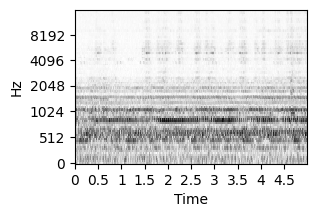

rank        : 0
source file : soundscape_unlabeled_data/CH11_SN06_20220725_053000.WAV
offset_s    : 50.00
score       : -3.28


Button(description='Aegolius harrisii_Buff-fronted Owl', style=ButtonStyle())

Button(description='Antrostomus rufus_Rufous Nightjar', style=ButtonStyle())

Button(description='Antrostomus sericocaudatus_Silky-tailed Nightjar', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_call', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_song', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_call', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_song', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_call', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_song', style=ButtonStyle())

Button(description='Background', style=ButtonStyle())

Button(description='Baryphthengus ruficapillus_Rufous-capped Motmot', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_call', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_song', style=ButtonStyle())

Button(description='Crypturellus obsoletus_Brown Tinamou', style=ButtonStyle())

Button(description='Dog', style=ButtonStyle())

Button(description='Engine', style=ButtonStyle())

Button(description='Frog', style=ButtonStyle())

Button(description='Glaucidium brasilianum_Ferruginous Pygmy-Owl', style=ButtonStyle())

Button(description='Human', style=ButtonStyle())

Button(description='Lurocalis semitorquatus_Short-tailed Nighthawk', style=ButtonStyle())

Button(description='Megascops atricapilla_Black-capped Screech-Owl', style=ButtonStyle())

Button(description='Megascops choliba_Tropical Screech-Owl', style=ButtonStyle())

Button(description='Megascops sanctaecatarinae_Long-tufted Screech-Owl', style=ButtonStyle())

Button(description='Nyctibius aethereus_Long-tailed Potoo', style=ButtonStyle())

Button(description='Nyctibius griseus_Common Potoo', style=ButtonStyle())

Button(description='Nyctidromus albicollis_Common Pauraque', style=ButtonStyle())

Button(description='Nyctiphrynus ocellatus_Ocellated Poorwill', style=ButtonStyle())

Button(description='Odontophorus capueira_Spot-winged Wood-Quail', style=ButtonStyle())

Button(description='Pulsatrix koeniswaldiana_Tawny-browed Owl', style=ButtonStyle())

Button(description='Rain', style=ButtonStyle())

Button(description='Rooster', style=ButtonStyle())

Button(description='Setopagis parvula_Little Nightjar', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call1', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_song', style=ButtonStyle())

Button(description='Tyto alba_Barn Owl', style=ButtonStyle())

--------------------------------------------------------------------------------


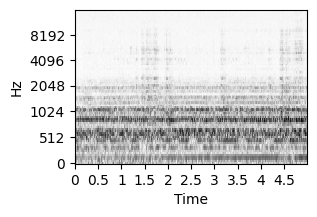

rank        : 1
source file : soundscape_unlabeled_data/CH11_SN06_20220725_053000.WAV
offset_s    : 95.00
score       : -3.19


Button(description='Aegolius harrisii_Buff-fronted Owl', style=ButtonStyle())

Button(description='Antrostomus rufus_Rufous Nightjar', style=ButtonStyle())

Button(description='Antrostomus sericocaudatus_Silky-tailed Nightjar', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_call', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_song', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_call', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_song', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_call', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_song', style=ButtonStyle())

Button(description='Background', style=ButtonStyle())

Button(description='Baryphthengus ruficapillus_Rufous-capped Motmot', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_call', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_song', style=ButtonStyle())

Button(description='Crypturellus obsoletus_Brown Tinamou', style=ButtonStyle())

Button(description='Dog', style=ButtonStyle())

Button(description='Engine', style=ButtonStyle())

Button(description='Frog', style=ButtonStyle())

Button(description='Glaucidium brasilianum_Ferruginous Pygmy-Owl', style=ButtonStyle())

Button(description='Human', style=ButtonStyle())

Button(description='Lurocalis semitorquatus_Short-tailed Nighthawk', style=ButtonStyle())

Button(description='Megascops atricapilla_Black-capped Screech-Owl', style=ButtonStyle())

Button(description='Megascops choliba_Tropical Screech-Owl', style=ButtonStyle())

Button(description='Megascops sanctaecatarinae_Long-tufted Screech-Owl', style=ButtonStyle())

Button(description='Nyctibius aethereus_Long-tailed Potoo', style=ButtonStyle())

Button(description='Nyctibius griseus_Common Potoo', style=ButtonStyle())

Button(description='Nyctidromus albicollis_Common Pauraque', style=ButtonStyle())

Button(description='Nyctiphrynus ocellatus_Ocellated Poorwill', style=ButtonStyle())

Button(description='Odontophorus capueira_Spot-winged Wood-Quail', style=ButtonStyle())

Button(description='Pulsatrix koeniswaldiana_Tawny-browed Owl', style=ButtonStyle())

Button(description='Rain', style=ButtonStyle())

Button(description='Rooster', style=ButtonStyle())

Button(description='Setopagis parvula_Little Nightjar', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call1', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_song', style=ButtonStyle())

Button(description='Tyto alba_Barn Owl', style=ButtonStyle())

--------------------------------------------------------------------------------


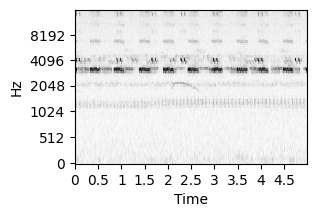

rank        : 2
source file : soundscape_unlabeled_data/CH17_SN02_20220724_202000.WAV
offset_s    : 50.00
score       : -3.19


Button(description='Aegolius harrisii_Buff-fronted Owl', style=ButtonStyle())

Button(description='Antrostomus rufus_Rufous Nightjar', style=ButtonStyle())

Button(description='Antrostomus sericocaudatus_Silky-tailed Nightjar', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_call', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_song', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_call', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_song', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_call', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_song', style=ButtonStyle())

Button(description='Background', style=ButtonStyle())

Button(description='Baryphthengus ruficapillus_Rufous-capped Motmot', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_call', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_song', style=ButtonStyle())

Button(description='Crypturellus obsoletus_Brown Tinamou', style=ButtonStyle())

Button(description='Dog', style=ButtonStyle())

Button(description='Engine', style=ButtonStyle())

Button(description='Frog', style=ButtonStyle())

Button(description='Glaucidium brasilianum_Ferruginous Pygmy-Owl', style=ButtonStyle())

Button(description='Human', style=ButtonStyle())

Button(description='Lurocalis semitorquatus_Short-tailed Nighthawk', style=ButtonStyle())

Button(description='Megascops atricapilla_Black-capped Screech-Owl', style=ButtonStyle())

Button(description='Megascops choliba_Tropical Screech-Owl', style=ButtonStyle())

Button(description='Megascops sanctaecatarinae_Long-tufted Screech-Owl', style=ButtonStyle())

Button(description='Nyctibius aethereus_Long-tailed Potoo', style=ButtonStyle())

Button(description='Nyctibius griseus_Common Potoo', style=ButtonStyle())

Button(description='Nyctidromus albicollis_Common Pauraque', style=ButtonStyle())

Button(description='Nyctiphrynus ocellatus_Ocellated Poorwill', style=ButtonStyle())

Button(description='Odontophorus capueira_Spot-winged Wood-Quail', style=ButtonStyle())

Button(description='Pulsatrix koeniswaldiana_Tawny-browed Owl', style=ButtonStyle())

Button(description='Rain', style=ButtonStyle())

Button(description='Rooster', style=ButtonStyle())

Button(description='Setopagis parvula_Little Nightjar', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call1', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_song', style=ButtonStyle())

Button(description='Tyto alba_Barn Owl', style=ButtonStyle())

--------------------------------------------------------------------------------


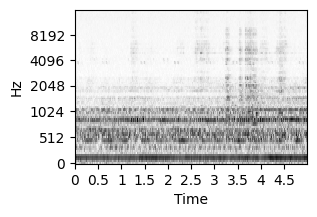

rank        : 3
source file : soundscape_unlabeled_data/CH11_SN06_20220725_053000.WAV
offset_s    : 30.00
score       : -3.10


Button(description='Aegolius harrisii_Buff-fronted Owl', style=ButtonStyle())

Button(description='Antrostomus rufus_Rufous Nightjar', style=ButtonStyle())

Button(description='Antrostomus sericocaudatus_Silky-tailed Nightjar', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_call', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_song', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_call', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_song', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_call', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_song', style=ButtonStyle())

Button(description='Background', style=ButtonStyle())

Button(description='Baryphthengus ruficapillus_Rufous-capped Motmot', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_call', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_song', style=ButtonStyle())

Button(description='Crypturellus obsoletus_Brown Tinamou', style=ButtonStyle())

Button(description='Dog', style=ButtonStyle())

Button(description='Engine', style=ButtonStyle())

Button(description='Frog', style=ButtonStyle())

Button(description='Glaucidium brasilianum_Ferruginous Pygmy-Owl', style=ButtonStyle())

Button(description='Human', style=ButtonStyle())

Button(description='Lurocalis semitorquatus_Short-tailed Nighthawk', style=ButtonStyle())

Button(description='Megascops atricapilla_Black-capped Screech-Owl', style=ButtonStyle())

Button(description='Megascops choliba_Tropical Screech-Owl', style=ButtonStyle())

Button(description='Megascops sanctaecatarinae_Long-tufted Screech-Owl', style=ButtonStyle())

Button(description='Nyctibius aethereus_Long-tailed Potoo', style=ButtonStyle())

Button(description='Nyctibius griseus_Common Potoo', style=ButtonStyle())

Button(description='Nyctidromus albicollis_Common Pauraque', style=ButtonStyle())

Button(description='Nyctiphrynus ocellatus_Ocellated Poorwill', style=ButtonStyle())

Button(description='Odontophorus capueira_Spot-winged Wood-Quail', style=ButtonStyle())

Button(description='Pulsatrix koeniswaldiana_Tawny-browed Owl', style=ButtonStyle())

Button(description='Rain', style=ButtonStyle())

Button(description='Rooster', style=ButtonStyle())

Button(description='Setopagis parvula_Little Nightjar', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call1', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_song', style=ButtonStyle())

Button(description='Tyto alba_Barn Owl', style=ButtonStyle())

--------------------------------------------------------------------------------


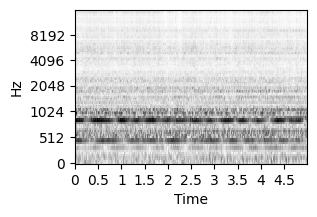

rank        : 4
source file : soundscape_unlabeled_data/CH11_SN06_20220725_053000.WAV
offset_s    : 115.00
score       : -2.91


Button(description='Aegolius harrisii_Buff-fronted Owl', style=ButtonStyle())

Button(description='Antrostomus rufus_Rufous Nightjar', style=ButtonStyle())

Button(description='Antrostomus sericocaudatus_Silky-tailed Nightjar', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_call', style=ButtonStyle())

Button(description='Asio clamator_Striped Owl_song', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_call', style=ButtonStyle())

Button(description='Asio stygius_Stygian Owl_song', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_call', style=ButtonStyle())

Button(description='Athene cunicularia_Burrowing Owl_song', style=ButtonStyle())

Button(description='Background', style=ButtonStyle())

Button(description='Baryphthengus ruficapillus_Rufous-capped Motmot', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_call', style=ButtonStyle())

Button(description='Ciccaba virgata_Mottled Owl_song', style=ButtonStyle())

Button(description='Crypturellus obsoletus_Brown Tinamou', style=ButtonStyle())

Button(description='Dog', style=ButtonStyle())

Button(description='Engine', style=ButtonStyle())

Button(description='Frog', style=ButtonStyle())

Button(description='Glaucidium brasilianum_Ferruginous Pygmy-Owl', style=ButtonStyle())

Button(description='Human', style=ButtonStyle())

Button(description='Lurocalis semitorquatus_Short-tailed Nighthawk', style=ButtonStyle())

Button(description='Megascops atricapilla_Black-capped Screech-Owl', style=ButtonStyle())

Button(description='Megascops choliba_Tropical Screech-Owl', style=ButtonStyle())

Button(description='Megascops sanctaecatarinae_Long-tufted Screech-Owl', style=ButtonStyle())

Button(description='Nyctibius aethereus_Long-tailed Potoo', style=ButtonStyle())

Button(description='Nyctibius griseus_Common Potoo', style=ButtonStyle())

Button(description='Nyctidromus albicollis_Common Pauraque', style=ButtonStyle())

Button(description='Nyctiphrynus ocellatus_Ocellated Poorwill', style=ButtonStyle())

Button(description='Odontophorus capueira_Spot-winged Wood-Quail', style=ButtonStyle())

Button(description='Pulsatrix koeniswaldiana_Tawny-browed Owl', style=ButtonStyle())

Button(description='Rain', style=ButtonStyle())

Button(description='Rooster', style=ButtonStyle())

Button(description='Setopagis parvula_Little Nightjar', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_call1', style=ButtonStyle())

Button(description='Strix hylophila_Rusty-barred Owl_song', style=ButtonStyle())

Button(description='Tyto alba_Barn Owl', style=ButtonStyle())

--------------------------------------------------------------------------------
Results Page: 1 / 2


Button(description='Prev Page', disabled=True, style=ButtonStyle())

Button(description='Next Page', style=ButtonStyle())

In [66]:
#@title Display results for the target label. { vertical-output: true }

display_labels = merged.labels

#@markdown Specify any extra labels you would like displayed.
#extra_labels = ['Unknown']  #@param
#for label in extra_labels:
  #if label not in merged.labels:
    #display_labels += (label,)
#if 'Unknown' not in merged.labels:
  #display_labels += ('Unknown',)

samples_per_page = 5
page_state = display.PageState(
    np.ceil(len(results.search_results) / samples_per_page))

display.display_paged_results(
    results, page_state, samples_per_page,
    project_state=project_state,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    exclusive_labels=False,
    checkbox_labels=display_labels,
    max_workers=5,
)

In [56]:
#@title Add selected results to the labeled data. { vertical-output: true }

results.write_labeled_data(
    bootstrap_config.annotated_path,
    project_state.embedding_model.sample_rate)

Wrote 2 examples for label Engine exists


In [ ]:
#@title Save the Custom Classifier. { vertical-output: true }

wrapped_model = zoo_interface.LogitsOutputHead(
    model_path=custom_classifier_path.as_posix(),
    logits_key='logits',
    logits_model=model,
    class_list=namespace.ClassList('custom', merged.labels),
)
wrapped_model.save_model(
    custom_classifier_path,
    embeddings_path)

## Inference

In [ ]:
#@title Write classifier inference CSV. { vertical-output: true }

#@markdown This cell writes detections (locations of audio windows where
#@markdown the logit was greater than a threshold) to a CSV file.

output_filepath = epath.Path(working_dir) / 'inference.csv'  #@param

#@markdown Set the default detection thresholds, used for all classes.
#@markdown To set per-class detection thresholds, modify the code below.
#@markdown Keep in mind that thresholds are on the logit scale, so 0.0
#@markdown corresponds to a 50% model confidence.
default_threshold = None #@param
if default_threshold is None:
  # In this case, all logits are written. This can lead to very large CSV files.
  class_thresholds = None
else:
  class_thresholds = collections.defaultdict(lambda: default_threshold)
  # Add any per-class thresholds here.
  class_thresholds[] = -10

#@markdown Classes to ignore when counting detections.
exclude_classes = ['Background']  #@param

#@markdown The `include_classes` list is ignored if empty.
#@markdown If non-empty, only scores for these classes will be written.
include_classes = []  #@param

embeddings_ds = project_state.create_embeddings_dataset(
    shuffle_files=True)
classify.write_inference_csv(
    embeddings_ds=embeddings_ds,
    model=model,
    labels=merged.labels,
    output_filepath=output_filepath,
    threshold=class_thresholds,
    embedding_hop_size_s=bootstrap_config.embedding_hop_size_s,
    include_classes=include_classes,
    exclude_classes=exclude_classes)
